# Introduction

This work will serve as an introduction to handling integral field spectroscopy data. To do this, we will start with a data cube from which we will extract information and obtain various images of the galaxy. These images will include the galaxy at a specific wavelength, spectra from different regions of the galaxy, and images in the $r$ and $i$ bands along with the corresponding $r-i$ color image.

# Libraries

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.aperture import CircularAperture, aperture_photometry

# Data Cube

In [2]:
sorted(glob.glob('*fits'))

['ESO113-G032.fits',
 'galaxy_HIIregions221.fits',
 'galaxy_HIIregions2210.fits',
 'galaxy_HIIregions2211.fits',
 'galaxy_HIIregions222.fits',
 'galaxy_HIIregions223.fits',
 'galaxy_HIIregions224.fits',
 'galaxy_HIIregions225.fits',
 'galaxy_HIIregions226.fits',
 'galaxy_HIIregions227.fits',
 'galaxy_HIIregions228.fits',
 'galaxy_HIIregions229.fits',
 'galaxy_HIIregions801.fits',
 'galaxy_HIIregions8010.fits',
 'galaxy_HIIregions8011.fits',
 'galaxy_HIIregions8012.fits',
 'galaxy_HIIregions8013.fits',
 'galaxy_HIIregions8014.fits',
 'galaxy_HIIregions8015.fits',
 'galaxy_HIIregions8016.fits',
 'galaxy_HIIregions8017.fits',
 'galaxy_HIIregions8018.fits',
 'galaxy_HIIregions8019.fits',
 'galaxy_HIIregions802.fits',
 'galaxy_HIIregions8020.fits',
 'galaxy_HIIregions8021.fits',
 'galaxy_HIIregions8022.fits',
 'galaxy_HIIregions8023.fits',
 'galaxy_HIIregions8024.fits',
 'galaxy_HIIregions8025.fits',
 'galaxy_HIIregions8026.fits',
 'galaxy_HIIregions8027.fits',
 'galaxy_HIIregions8028.fits'

We open the data cube and examine the information it contains.

In [3]:
cube = fits.open('ESO113-G032.fits')
print(cube.info())

Filename: ESO113-G032.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1532   ()      
  1  DATA          1 CompImageHDU     75   (408, 327, 3681)   float32   
  2  STAT          1 CompImageHDU     47   (408, 327, 3681)   float32   
None


We obtain the information from the *header* where the data is located.

In [4]:
print(repr( cube[1].header))

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  408 / length of data axis 1                          
NAXIS2  =                  327 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ZBLANK  =          -2147483647 / null value in the compressed integer array     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

In [5]:
#We extract information.
ndim = cube[1].header['NAXIS']              #Dimension number
x_axislength = cube[1].header['NAXIS1']     #Length of x-axis
y_axislength = cube[1].header['NAXIS2']     #Length of y-axis
z_axislength = cube[1].header['NAXIS3']     #Length of z-axis
pixelscale_x = cube[1].header['CD1_1']      #RA pixel scale
pixelscale_y = cube[1].header['CD2_2']      #DEC pixel scale
lambda_scale = cube[1].header['CD3_3']      #wave length scale

In [6]:
#Reference pixel and its value
CRPIX1 = cube[1].header['CRPIX1']
CRVAL1 = cube[1].header['CRVAL1']
CRPIX2 = cube[1].header['CRPIX2']
CRVAL2 = cube[1].header['CRVAL2']
CRPIX3 = cube[1].header['CRPIX3']
CRVAL3 = cube[1].header['CRVAL3']

In [7]:
data = cube[1].data
data.shape

(3681, 327, 408)

# Galaxy image at different wavelengths

We take different wavelengths. Since the dimensions are in pixels, we need to convert pixels to Ångströms to know which wavelength we are observing. Likewise, the reverse conversion can be done if we want a specific wavelength.

In [8]:
galaxy_3500 = data[3500, :, :]

#Conversion: Pixels to Ångströms
Lambda_3500 = lambda_scale * (3500 - CRPIX3) + CRVAL3

In [9]:
galaxy_500 = data[500, :, :]

#Conversion: Pixels to Ångströms
Lambda_500 = lambda_scale * (500 - CRPIX3) + CRVAL3

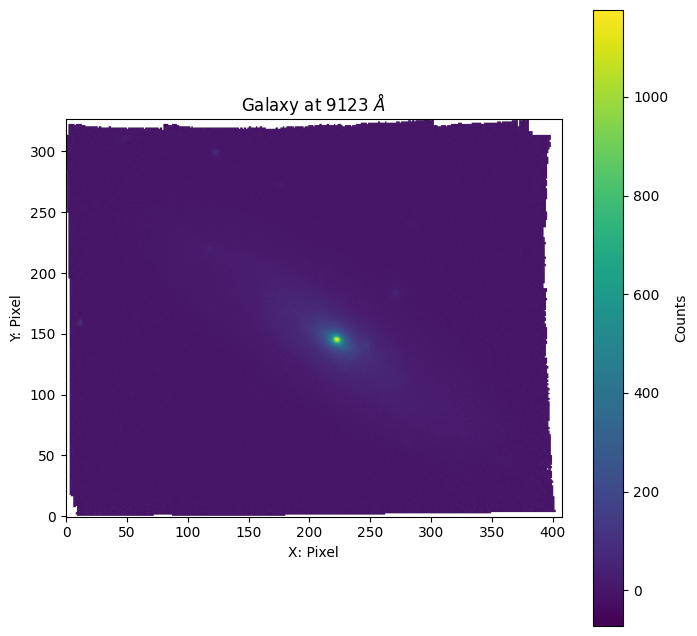

In [10]:
plt.figure("galaxy at 9123", figsize=(8,8))
plt.title(f'Galaxy at {int(Lambda_3500)} $\AA$')
plt.imshow(galaxy_3500, origin="lower")
plt.xlabel('X: Pixel')
plt.ylabel('Y: Pixel')
plt.colorbar(label="Counts")
plt.show()

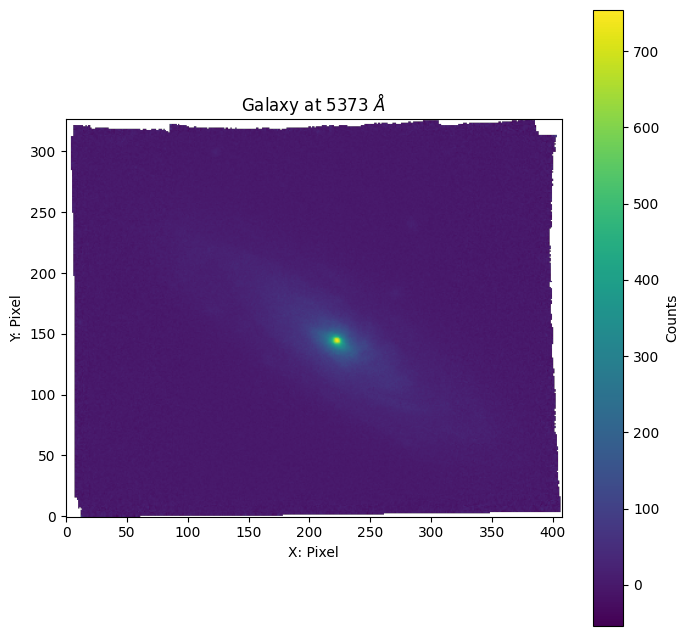

In [11]:
plt.figure("galaxy at 5373", figsize=(8,8))
plt.title(f'Galaxy at {int(Lambda_500)} $\AA$')
plt.imshow(galaxy_500, origin="lower")
plt.xlabel('X: Pixel')
plt.ylabel('Y: Pixel')
plt.colorbar(label="Counts")
plt.show()

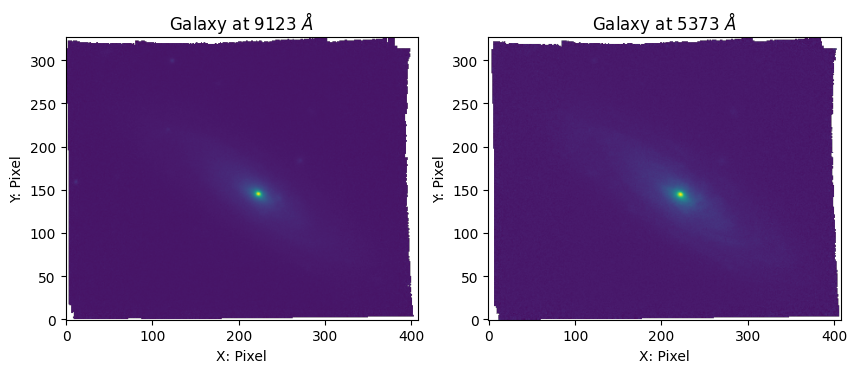

In [12]:
plt.figure("galaxy at diferent Ångström", figsize=(10,10))
plt.subplot(121)
plt.title(f'Galaxy at {int(Lambda_3500)} $\AA$')
gal1 = plt.imshow(galaxy_3500, origin="lower")
plt.xlabel('X: Pixel')
plt.ylabel('Y: Pixel')
plt.subplot(122)
plt.title(f'Galaxy at {int(Lambda_500)} $\AA$')
gal2 = plt.imshow(galaxy_500, origin="lower")
plt.xlabel('X: Pixel')
plt.ylabel('Y: Pixel')
plt.show()

# Spectrums

Now we will take the spectrum for different points in the galaxy. To obtain the wavelength range, we will convert the pixels into Ångströms.

In [13]:
# We convert al pixel into Angtroms
Lambda = [lambda_scale * (i - CRPIX3) + CRVAL3 for i in range(z_axislength)]      

In [14]:
# At x = 20 and y = 20
x1 = 20
y1 = 20                                                           
galaxy_2020 = data[:, x1, y1]

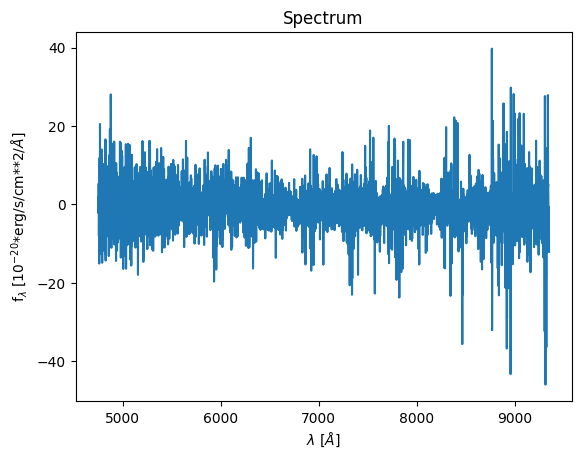

In [15]:
plt.figure(1)
plt.plot(Lambda, galaxy_2020)
plt.title('Spectrum')
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('f$_{\lambda}$ [$10^{-20}$*erg/s/cm**2/$\AA$]')
plt.show()

In [16]:
x2 = 200
y2 = 20
galaxy2 = data[:, x2, y2]

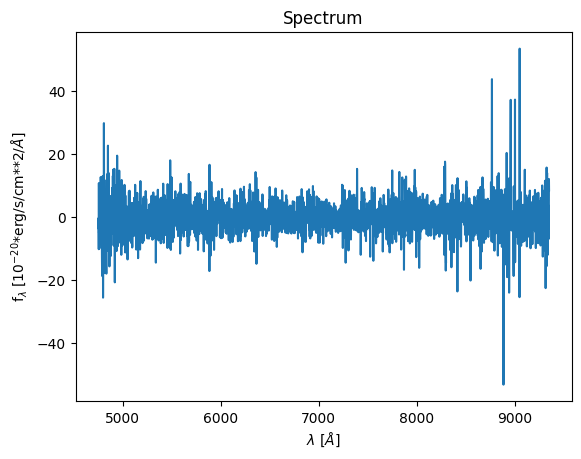

In [17]:
plt.figure(2)
plt.plot(Lambda, galaxy2)
plt.title('Spectrum')
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('f$_{\lambda}$ [$10^{-20}$*erg/s/cm**2/$\AA$]')
plt.show()

# White Image

https://docs.astropy.org/en/stable/wcs/index.html

https://photutils.readthedocs.io/en/stable/user_guide/detection.html

In this section, we obtain a white-light image of the galaxy; that is, we integrate over all wavelengths. Additionally, as we will see, the galaxy will not be centered in the image, so we will need to make an adjustment.

In [18]:
# We convert pixels into arcsec
arcsec_x = [pixelscale_x * (i - CRPIX1) + CRVAL1 for i in range(x_axislength)]
arcsec_y = [pixelscale_y * (i - CRPIX2) + CRVAL2 for i in range(y_axislength)]

In [182]:
xmin = np.min(arcsec_x)
xmax = np.max(arcsec_x)
ymin = np.min(arcsec_y)
ymax = np.max(arcsec_y)
xmedian = np.median (arcsec_x)
ymedian = np.median(arcsec_y)
extent = [-xmedian, xmedian, ymedian, -ymedian]

In [28]:
data1 = np.sum(data, axis=0)

We obtain the galaxy’s coordinates in RA and Dec from the NED catalog and convert them to image coordinates using the WCS function from astropy.

In [29]:
RA=19.020372 * u.deg
Dec=-61.622233 * u.deg
coords= SkyCoord(RA, Dec)
w = WCS(cube[1].header)
x_pixel, y_pixel, z_pixel = w.world_to_pixel(coords, 5000e-10*u.m)
print(x_pixel, y_pixel, z_pixel )

209.15220289993596 134.1093037293557 200.15156249999978


In [37]:
x_pixel_arc

[np.float64(19.02329303599263)]

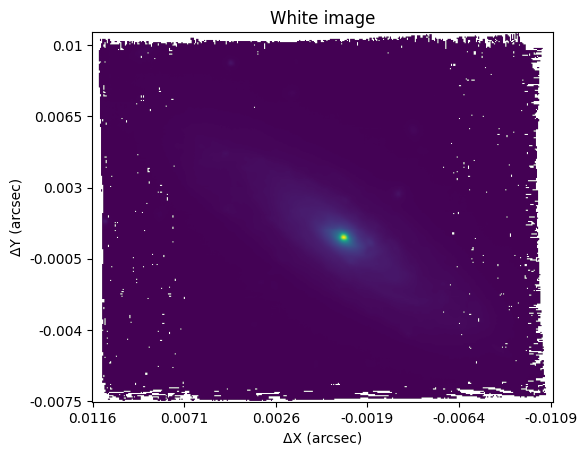

In [48]:
x_range = np.arange(0, 408, 408//15)
y_range = np.arange(0, 327, 327//15)

x_pixel_arc = pixelscale_x * (x_pixel - CRPIX1) + CRVAL1
y_pixel_arc = pixelscale_y * (y_pixel - CRPIX2) + CRVAL2
x_range_arc = pixelscale_x * (x_range - CRPIX1) + CRVAL1
y_range_arc = pixelscale_y * (y_range - CRPIX2) + CRVAL2

x_axis_arc = np.round(x_range_arc - x_pixel_arc, 4)
y_axis_arc = np.round(y_range_arc - y_pixel_arc, 4)

#data2=data1[int(y_pixel)-100:int(y_pixel)+100, int(x_pixel)-100:int(x_pixel)+100]
fig, ax = plt.subplots()
plt.imshow(data1, origin="lower")
plt.title('White image')
ax.set_xticks(x_range[::3], labels=x_axis_arc[::3])
ax.set_yticks(y_range[::3], labels=y_axis_arc[::3])
plt.xlabel('ΔX (arcsec)')
plt.ylabel('ΔY (arcsec)')
plt.show()


We can see that the image is not fully centered, so we will use the DAOStarFinder tool to locate the center of the galaxy in the image.

In [49]:
def imstats(data):
    """
    Calcula parámetros estadísticos como el total, máximo, mínimo, media, mediana y desviación de un conjunto de datos ignorando los valores NaNs.

    Parámetros
    ----------
    data : numpy.ndarray
        Array de un conjunto de datos.

    Retorna
    -------
    dict
        Un diccionario con las siguientes estadísticas:
        - 'total': número total de elementos en la matriz de datos.
        - 'minimum': valor mínimo ignorando los valores NaNs.
        - 'maximum': valor máximo ignorando los valores NaNs.
        - 'average': media ignorando los valores NaNs.
        - 'median': mediana ignorando los valores NaNs.
        - 'desviation': desviación estándar ignorando los valores NaNs.
    """
    x, y = np.shape(data)[0], np.shape(data)[1]
    stad = x * y, float(np.nanmin(data)), float(np.nanmax(data)), float(np.nanmean(data)), float(np.nanmedian(data)), float(np.nanstd(data))
    dicti = {'total':stad[0], 'minimum':stad[1], 'maximum':stad[2], 
             'average':stad[3], 'median':stad[4], 'desviation':stad[5]}
    return dicti

In [50]:
mean, median, std = sigma_clipped_stats(data1, sigma=3.0)
std = imstats(data1)['desviation']
daofind = DAOStarFinder(fwhm=1.0, threshold=3.*std)
sources = daofind(data1)
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)

 id xcentroid ycentroid sharpness ...     flux     mag   daofind_mag
--- --------- --------- --------- ... ----------- ------ -----------
  1    221.76    145.27      0.86 ... 71342008.00 -19.63       -0.59


In [51]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=11.0)

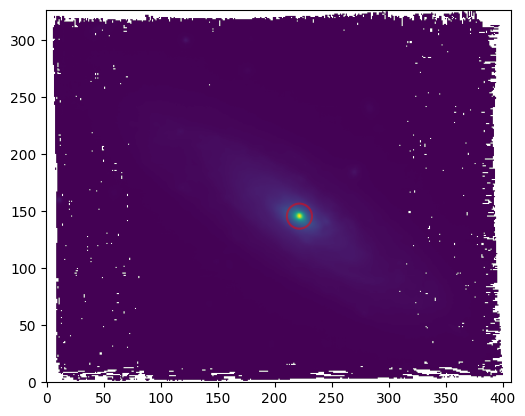

In [55]:
plt.figure("Center galaxy", figsize=(6, 6))
plt.imshow(
    data1, 
    #vmin=np.median(data1) - 1 * imstats(data1)['desviation'],          
    #vmax=np.median(data1) + 1 * imstats(data1)['desviation'],  
    origin="lower"
)
apertures.plot(color='red', lw=1.5, alpha=0.5)
#plt.colorbar(label="Counts")
plt.show()

In [53]:
x_center=int(sources['xcentroid'])
y_center=int(sources['ycentroid'])

/tmp/ipykernel_2991/1725973910.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_center=int(sources['xcentroid'])
/tmp/ipykernel_2991/1725973910.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_center=int(sources['ycentroid'])


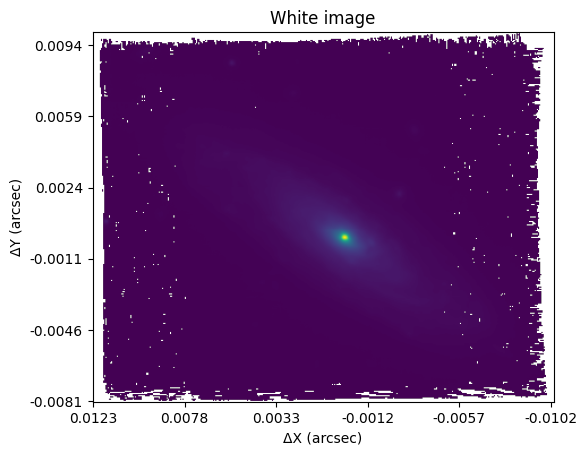

In [54]:
x_center_arc = pixelscale_x * (x_center - CRPIX1) + CRVAL1
y_center_arc = pixelscale_y * (y_center - CRPIX2) + CRVAL2
x_axis_arc = np.round(x_range_arc - x_center_arc, 4)
y_axis_arc = np.round(y_range_arc - y_center_arc, 4)

fig, ax = plt.subplots()
plt.imshow(data1, origin="lower")
plt.title('White image')
ax.set_xticks(x_range[::3], labels=x_axis_arc[::3])
ax.set_yticks(y_range[::3], labels=y_axis_arc[::3])
plt.xlabel('ΔX (arcsec)')
plt.ylabel('ΔY (arcsec)')
plt.show()

# Image in the r-band and i-band

We will study the galaxy in both bands and then create the r-i color map to locate dust regions and old stellar populations. We will start by calculating the wavelength ranges for each band.

In [57]:
pixel_lambda1 = int((5500 - CRVAL3) / lambda_scale + CRPIX3)
pixel_lambda2 = int((7000 - CRVAL3) / lambda_scale + CRPIX3)
pixel_lambda3 = int((8500 - CRVAL3) / lambda_scale + CRPIX3)

In [58]:
data_reduce_r = data[pixel_lambda1:pixel_lambda2, :, :]
data_r = np.sum(data_reduce_r, axis=0)

In [59]:
data_reduce_i=data[pixel_lambda2:pixel_lambda3, :, :]
data_i=np.sum(data_reduce_i, axis=0)

In [60]:
range_band_r = 7000 - 5500
range_band_i = 8500 - 7000

In [61]:
flux_density_r = (data_r / range_band_r) * 10**(-20)
flux_density_i = (data_i / range_band_i) * 10**(-20)

We calculate magnitudes.

In [62]:
mag_r = -2.5 * np.log10(flux_density_r) - 21.1
mag_i = -2.5 * np.log10(flux_density_i) - 21.1

/tmp/ipykernel_2991/679291450.py:1: RuntimeWarning: invalid value encountered in log10
  mag_r = -2.5 * np.log10(flux_density_r) - 21.1
/tmp/ipykernel_2991/679291450.py:2: RuntimeWarning: invalid value encountered in log10
  mag_i = -2.5 * np.log10(flux_density_i) - 21.1


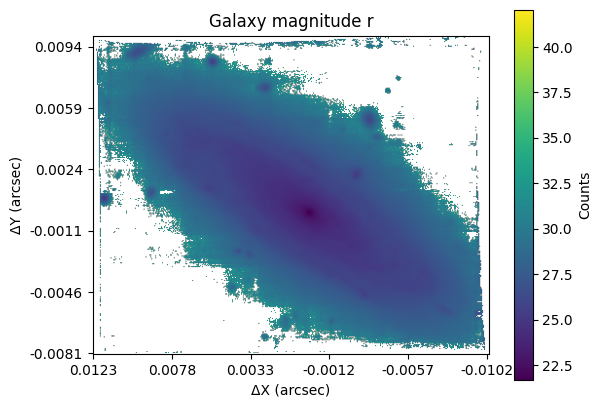

In [66]:
fig, ax = plt.subplots()
plt.imshow(mag_r, origin="lower")
plt.title('Galaxy magnitude r')
ax.set_xticks(x_range[::3], labels=x_axis_arc[::3])
ax.set_yticks(y_range[::3], labels=y_axis_arc[::3])
plt.colorbar(label="Counts")
plt.xlabel('ΔX (arcsec)')
plt.ylabel('ΔY (arcsec)')
plt.show()

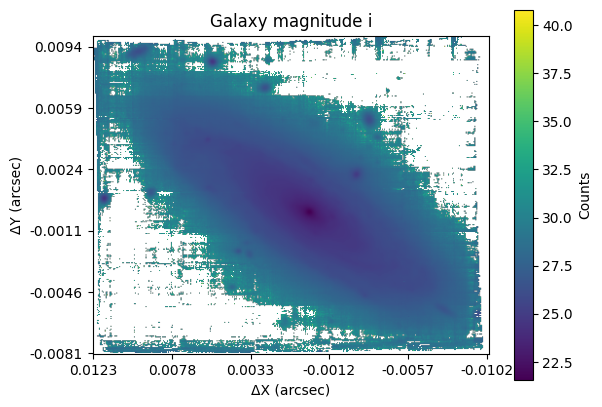

In [67]:
fig, ax = plt.subplots()
plt.imshow(mag_i, origin="lower")
plt.title('Galaxy magnitude i')
ax.set_xticks(x_range[::3], labels=x_axis_arc[::3])
ax.set_yticks(y_range[::3], labels=y_axis_arc[::3])
plt.colorbar(label="Counts")
plt.xlabel('ΔX (arcsec)')
plt.ylabel('ΔY (arcsec)')
plt.show()

# r - i color image

To obtain the r - i color image, we simply need to subtract the magnitudes. The result is as follows.

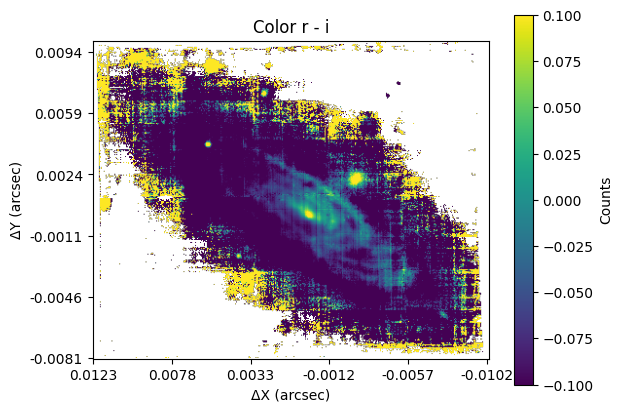

In [74]:
color = mag_r - mag_i
fig, ax = plt.subplots()
plt.imshow(
    color, 
    vmin=np.median(color) - 1 * imstats(color)['desviation'], 
    vmax=np.median(color) + 1 * imstats(color)['desviation'],
    origin="lower")
plt.title('Color r - i')
ax.set_xticks(x_range[::3], labels=x_axis_arc[::3])
ax.set_yticks(y_range[::3], labels=y_axis_arc[::3])
plt.colorbar(label="Counts")
plt.xlabel('ΔX (arcsec)')
plt.ylabel('ΔY (arcsec)')
plt.show()

In the more yellow areas, it corresponds to regions where the infrared predominates, and in the bluer areas, the red predominates. As we can see in the image, the infrared predominates in the nucleus and can also be found tracing the arms of the galaxy. This implies that in these regions, there is a large amount of interstellar dust that absorbs shorter wavelengths and emits in the infrared. Additionally, in the arms, there are areas where the red band predominates, which means that there is star formation in those regions.

# H$\alpha$ image

The H$\alpha$ line is located in the r-band, so to obtain an H$\alpha$ image, it is necessary to remove the entire continuum spectrum, which mainly comes from the stars, from the flux obtained for the H$\alpha$ wavelength.

We will take the H$\alpha$ wavelength corrected with the redshift obtained from the NED.

In [82]:
redshift = 0.029000
Lambda_Ha = 6563
Lambda_obs = Lambda_Ha * (1 + redshift)

What we will do to remove the continuum spectrum from the H$\alpha$ line is to take three bands: one centered on H$\alpha$ and the other two adjacent to it. By averaging the flux of the adjacent bands and subtracting it from the H$\alpha$ band, we will obtain the H$\alpha$ line.

In [83]:
bandHa_left = Lambda_obs - 50
bandHa_right = Lambda_obs + 50
band_left = bandHa_left - 100
band_right = bandHa_right + 100

In [84]:
pixel_lambdaHa = int((Lambda_obs - CRVAL3) / lambda_scale + CRPIX3)
pixel_bandHa_left = int((bandHa_left - CRVAL3) / lambda_scale + CRPIX3)
pixel_bandHa_right = int((bandHa_right - CRVAL3) / lambda_scale + CRPIX3)
pixel_band_left = int((band_left - CRVAL3) / lambda_scale + CRPIX3)
pixel_band_right = int((band_right - CRVAL3) / lambda_scale + CRPIX3)

In [85]:
band_Ha_data = data[pixel_bandHa_left:pixel_bandHa_right, :, :]
band_left_data = data[pixel_band_left:pixel_bandHa_left, :, :]
band_right_data = data[pixel_bandHa_right:pixel_band_right, :, :]

In [86]:
flux_band_left = np.sum(band_left_data, axis=0)
flux_band_right = np.sum(band_right_data, axis=0)
flux_band_Ha = np.sum(band_Ha_data, axis=0)
band_median = (flux_band_left + flux_band_right) / 2
free_continium = flux_band_Ha - band_median

We save the obtained image.

In [87]:
hdu_galaxyHii_region = fits.PrimaryHDU(free_continium.astype(np.float32))
hdu_galaxyHii_region.writeto('galaxy_Hiiregions.fits', overwrite=True)

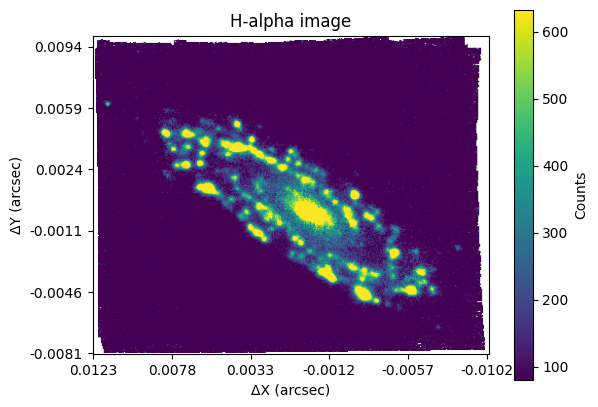

In [88]:
fig, ax = plt.subplots()
plt.imshow(
    free_continium,  
    vmin=imstats(free_continium)['median'] + 0.3 * imstats(free_continium)['desviation'], 
    vmax=imstats(free_continium)['median'] + 3.0 * imstats(free_continium)['desviation'],
    origin="lower")
plt.title('H-alpha image')
ax.set_xticks(x_range[::3], labels=x_axis_arc[::3])
ax.set_yticks(y_range[::3], labels=y_axis_arc[::3])
plt.colorbar(label="Counts")
plt.xlabel('ΔX (arcsec)')
plt.ylabel('ΔY (arcsec)')
plt.show()

# HII Spectrums

We now take the spectrum from different regions of the galaxy image in H$\alpha$. The points will be located at the center of the galaxy, as well as at the top and bottom of the disk. We will start by defining these points.

In [89]:
region_center = data[:, 149, 225]
region_disc_up = data[:, 210, 140]
region3_disc_down = data[:, 65, 275]

In the central part, we will mainly identify absorption lines, due to the absorption of light emitted by the stars, caused by the gas and dust concentrated in the center of the galaxy. One of the few emission lines that can be easily seen is the NII line, which we will use to calculate the redshift.

In [90]:
Lambda_NII = 6583
Lambda_obs_NII = Lambda_NII * (1 + redshift)

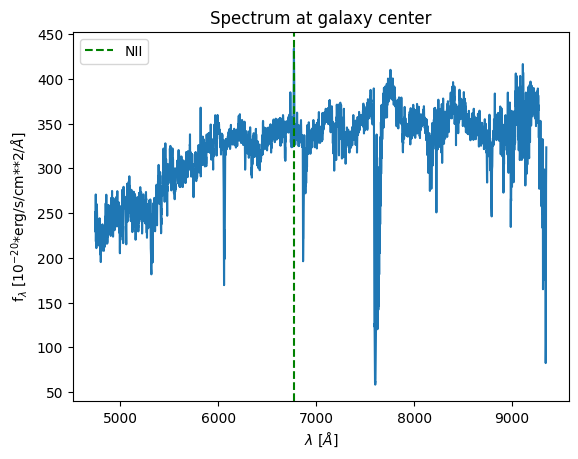

In [93]:
plt.figure('Es')
plt.plot(Lambda, region_center)
plt.title('Spectrum at galaxy center')
plt.axvline(x=Lambda_obs_NII, color='g', linestyle='--', label='NII')
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('f$_{\lambda}$ [$10^{-20}$*erg/s/cm**2/$\AA$]')
plt.legend(loc=2)
plt.show()

In [94]:
flux_LambdaNII_center = np.argmax(region_center)
LambdaNII_center = Lambda[flux_LambdaNII_center] 
LambdaNII_center

6773.560546875

In [95]:
redshift_center = (LambdaNII_center / Lambda_NII) - 1
redshift_center

0.028947371544128853

As we can see, the obtained redshift is very similar to the one provided in the NED.

Now, let's move on to the disk region. Here, we will find emission lines due to the ionized gas of HII. Specifically, we will find, as expected, the H$\alpha$ line, which will be our reference for calculating the redshift.

In [102]:
Lambda_NII = 6583
Lambda_obs_NII = Lambda_NII * (1 + redshift)
Lambda_Hb = 4861
Lambda_obs_Hb = Lambda_Hb * (1 + redshift)

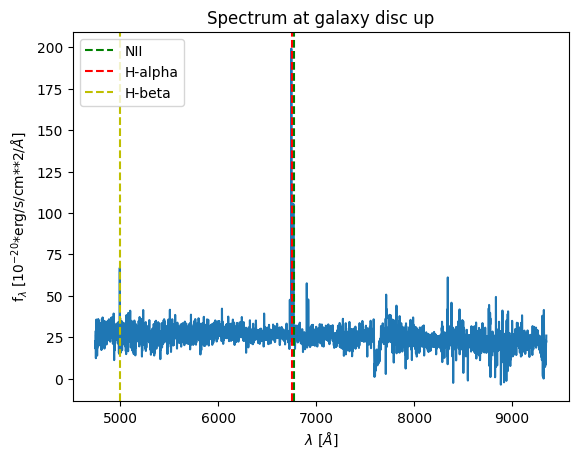

In [103]:
plt.figure('Es')
plt.plot(Lambda, region_disc_up)
plt.title('Spectrum at galaxy disc up')
plt.axvline(x=Lambda_obs_NII, color='g', linestyle='--', label='NII')
plt.axvline(x=Lambda_obs, color='r', linestyle='--', label='H-alpha')
plt.axvline(x=Lambda_obs_Hb, color='y', linestyle='--', label='H-beta')
plt.legend(loc=2)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('f$_{\lambda}$ [$10^{-20}$*erg/s/cm**2/$\AA$]')
plt.show()

In [104]:
flux_LambdaHa_disc_up = np.argmax(region_disc_up)
LambdaHa_disc_up = Lambda[flux_LambdaHa_disc_up] 
LambdaHa_disc_up

6747.310546875

In [105]:
redshift_disc_up = (LambdaHa_disc_up / Lambda_Ha) - 1
redshift_disc_up

0.028083276988419836

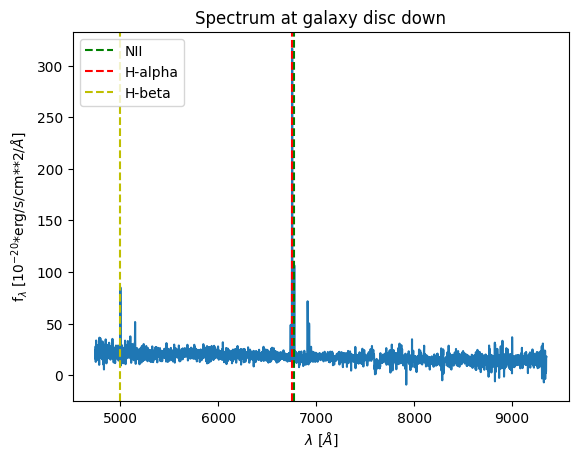

In [106]:
plt.figure('Es')
plt.plot(Lambda, region3_disc_down)
plt.title('Spectrum at galaxy disc down')
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('f$_{\lambda}$ [$10^{-20}$*erg/s/cm**2/$\AA$]')
plt.axvline(x=Lambda_obs_NII, color='g', linestyle='--', label='NII')
plt.axvline(x=Lambda_obs, color='r', linestyle='--', label='H-alpha')
plt.axvline(x=Lambda_obs_Hb, color='y', linestyle='--', label='H-beta')
plt.legend(loc=2)
plt.show()

In [107]:
flux_LambdaHa_disc_down = np.argmax(region3_disc_down)
LambdaHa_disc_down = Lambda[flux_LambdaHa_disc_down] 
LambdaHa_disc_down

6756.060546875

In [108]:
redshift_disc_down = (LambdaHa_disc_down / Lambda_Ha) - 1
redshift_disc_down

0.02941650874219115

As we can see, the redshift of the upper part of the galaxy is lower than that of the center and the lower part, with the latter being the region with the highest redshift. This is due to the galaxy's rotation. As the disk rotates around the nucleus, there will be a region moving towards us, another moving away, and two regions moving approximately parallel to us. For the first region, the redshift will be lower because the redshift due to the galaxy's motion must be counteracted by the rotational motion, which is bringing this region towards us. For the second region, the opposite occurs, leading to a higher redshift. For the third region, the redshift should be similar to that of the nucleus.

# Conclusion

We have successfully obtained the data from the data cube and used it to analyze the galaxy image across different wavelengths and bands, as well as to analyze spectra from different regions.

With the color image, we identified regions of star formation and interstellar dust, and with the H$\alpha$ image, in addition to locating the HII regions, we were able to obtain the redshift for each zone of the galaxy, allowing us to observe the effect of rotation on it. Finally, in the different spectra, we managed to identify the emission lines for the HII regions.